# Проект:  Определение стоимости автомобилей
**Описание исседования** <br>

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости.

**Признаки**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**

* Price — цена (евро)

**Содержание**

 [Шаг 1. Загрузка и подготовка данныx](#step1)
 
 [Шаг 2. Обучение моделей](#step2)
 
 [Шаг 3. Общий вывод](#step3)
 

<a id = 'step1'></a>
# Шаг 1. Загрузка и подготовка данных

In [42]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import os

from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from lightgbm import LGBMRegressor



import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
if os.path.exists('autos.csv'):
    data = pd.read_csv('autos.csv') #локальный путь
else:
    data = pd.read_csv('/datasets/autos.csv') #путь, указанный в проекте

In [44]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [46]:
data['NumberOfPictures'].describe()

count    354369.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

In [47]:
data.duplicated().sum()

4

In [48]:
data.drop_duplicates(inplace = True) 

In [49]:
#удалим ненужные столбцы 
data = data.drop(['DateCrawled', 'DateCreated', 'RegistrationMonth', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis = 1)

In [50]:
#пропуски
(data.isna().sum()/data.shape[0]).map('{:.2%}'.format)

Price                0.00%
VehicleType         10.58%
RegistrationYear     0.00%
Gearbox              5.60%
Power                0.00%
Model                5.56%
Kilometer            0.00%
FuelType             9.28%
Brand                0.00%
NotRepaired         20.08%
dtype: object

In [51]:
#data.isna().mean() * 100

**Комментарий студента**

 Тип кузова(VehicleType) можно попробовать восстановить по модели(Model) автомобиля

In [52]:
#группируем данные по модели и берем наиболее часто встречающийся тип кузова

model_vehicle = data.groupby("Model")['VehicleType'].agg(lambda x:x.value_counts().sort_values(ascending = False).index[0]).to_dict()
model_vehicle

{'100': 'sedan',
 '145': 'small',
 '147': 'sedan',
 '156': 'wagon',
 '159': 'wagon',
 '1_reihe': 'small',
 '1er': 'sedan',
 '200': 'sedan',
 '2_reihe': 'small',
 '300c': 'wagon',
 '3_reihe': 'sedan',
 '3er': 'sedan',
 '4_reihe': 'wagon',
 '500': 'small',
 '5_reihe': 'bus',
 '5er': 'sedan',
 '601': 'sedan',
 '6_reihe': 'wagon',
 '6er': 'coupe',
 '7er': 'sedan',
 '80': 'sedan',
 '850': 'wagon',
 '90': 'sedan',
 '900': 'convertible',
 '9000': 'sedan',
 '911': 'coupe',
 'a1': 'small',
 'a2': 'small',
 'a3': 'sedan',
 'a4': 'wagon',
 'a5': 'coupe',
 'a6': 'wagon',
 'a8': 'sedan',
 'a_klasse': 'sedan',
 'accord': 'sedan',
 'agila': 'small',
 'alhambra': 'bus',
 'almera': 'sedan',
 'altea': 'bus',
 'amarok': 'suv',
 'antara': 'suv',
 'arosa': 'small',
 'astra': 'sedan',
 'auris': 'sedan',
 'avensis': 'wagon',
 'aveo': 'small',
 'aygo': 'small',
 'b_klasse': 'bus',
 'b_max': 'bus',
 'beetle': 'sedan',
 'berlingo': 'bus',
 'bora': 'sedan',
 'boxster': 'convertible',
 'bravo': 'sedan',
 'c1': 's

In [53]:
#временно
data.Model.fillna(0, inplace=True)
data.VehicleType.fillna(0, inplace=True)

In [54]:
len(data[data['VehicleType'] == 0])

37490

In [55]:
#функция, которая принимает на вход строку
#и возвращает тип кузова, который зависит от модели

def define_vehicle(row):
    if row['Model'] != 0 and row['VehicleType'] == 0:
        row['VehicleType'] = model_vehicle[row['Model']]
        return row['VehicleType']
    else: 
        return row['VehicleType']
    
data['VehicleType'] = data.apply(define_vehicle, axis=1)

In [56]:
len(data[data['VehicleType'] == 0])

6828

In [57]:
data['VehicleType'].replace(0, np.nan, inplace=True)
data['Model'].replace(0, np.nan, inplace=True)

In [58]:
data['NotRepaired'].value_counts()

no     247158
yes     36053
Name: NotRepaired, dtype: int64

In [59]:
# Если NotRepaired пропущено, считаем, что продавец имеет в виду наличие ремонта ремонта
data['NotRepaired'].fillna('no', inplace=True)

data['FuelType'].fillna(data["FuelType"].mode().values[0], inplace=True)

In [60]:
(data.isna().sum()/data.shape[0]).map('{:.2%}'.format)

Price               0.00%
VehicleType         1.93%
RegistrationYear    0.00%
Gearbox             5.60%
Power               0.00%
Model               5.56%
Kilometer           0.00%
FuelType            0.00%
Brand               0.00%
NotRepaired         0.00%
dtype: object

In [61]:
#удалим остальные пропуски 
#оставили 10% данных
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [62]:
data.select_dtypes(include='number').describe()

,Price,RegistrationYear,Power,Kilometer
count,318958.000000,318958.000000,318958.000000,318958.000000
mean,4608.905502,2003.427031,114.965265,128844.738179
std,4564.241216,30.517461,185.627579,36620.680186
min,0.000000,1000.000000,0.000000,5000.000000
25%,1200.000000,1999.000000,75.000000,125000.000000
50%,2900.000000,2003.000000,105.000000,150000.000000
75%,6700.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9000.000000,20000.000000,150000.000000


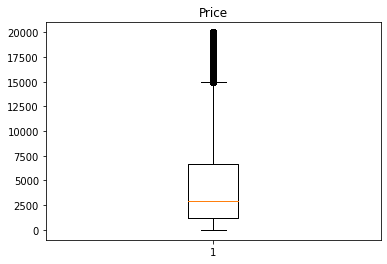

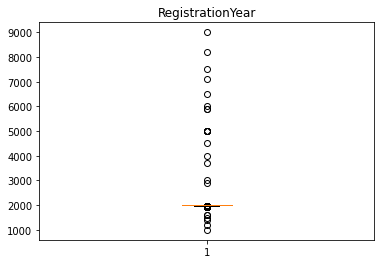

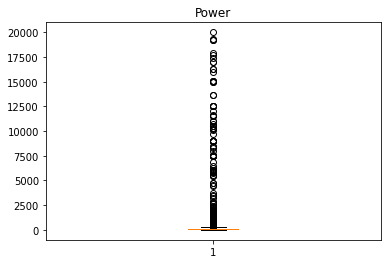

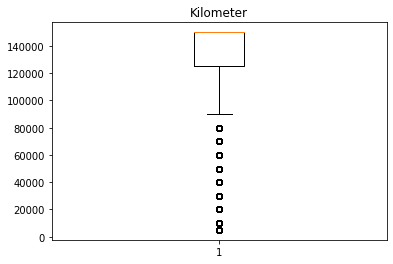

In [63]:
for column in data.select_dtypes(include='number'):
    plt.boxplot(data[column])
    plt.title(column)
    plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

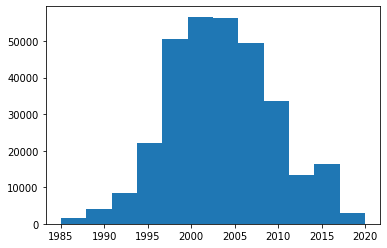

In [64]:
plt.hist(data['RegistrationYear'], bins = 12, range = (1985,2020)) 
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

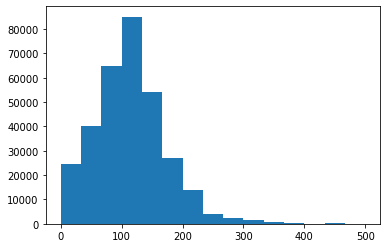

In [65]:
plt.hist(data['Power'], bins = 15, range = (0,500)) 
plt.show

**Комментарий студента**

 1. Значения из столбца Price обладают высоким стандартным отклонениям, что пагубно будет влиять на работу алгоритма (признак нуждается в поиске выбросов)
 2. В столбце RegistrationYear присутствуют аномальные значения. Можно установить диапазон, в котором может находится значение этого столбца. А именно, год регистрации не может быть больше 2016, и не может быть меньше 1985. Все показания выше или ниже этих значений приведем к максимальной или минимальной границе.
 3. В Power присутствуют аномальные значения (20 000 лошадиных сил) при том, что средняя мощность двигателя легкового автомобиля ~ 137.1 л.с. 
 4. В столбце Kilometer достаточно реалистичные значения

In [66]:
#корректируем год регистрации
def correct_year(year):
    if year > 2016:
        return 2016
    elif year < 1985:
        return 1985
    else:
        return year
    
data['RegistrationYear'] = data['RegistrationYear'].apply(correct_year)

<function matplotlib.pyplot.show(close=None, block=None)>

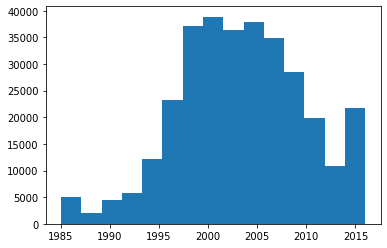

In [67]:
plt.hist(data['RegistrationYear'], bins = 15) 
plt.show

In [68]:
#корректируем мощность 
data.loc[data['Power']>500, 'Power'] = 137

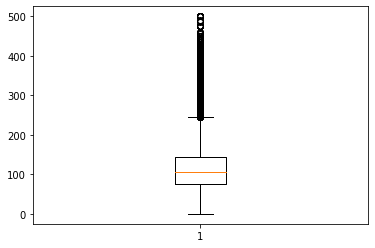

In [69]:
plt.boxplot(data['Power'])
plt.show()

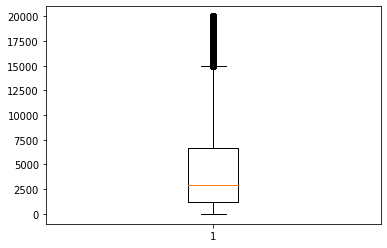

In [70]:
plt.boxplot(data['Price'])
plt.show()

In [71]:
q1 = data.Power.quantile(0.25)
q3 = data.Power.quantile(0.75)
#first_power = q1 - 1.5*(q3 - q1)
second_power = q3 + 1.5*(q3 - q1)

q1 = data.Price.quantile(0.25)
q3 = data.Price.quantile(0.75)
#first_price = q1 - 1.5*(q3 - q1)
second_price = q3 + 1.5*(q3 - q1)

In [72]:
data = data.query('Power < @second_power')
data = data.query('Price < @second_price')

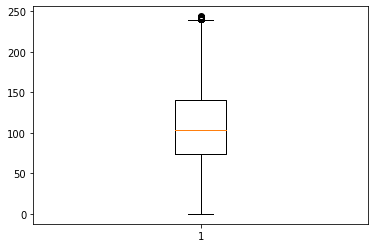

In [73]:
plt.boxplot(data['Power'])
plt.show()

In [74]:
#корректируем цену и мощность 

def correct_column(value, median_value):
    if value < median_value:
        return median_value
    else:
        return value
    
data['Price'] = data['Price'].apply(correct_column, median_value=data['Price'].median())
data['Power'] = data['Power'].apply(correct_column, median_value=data['Power'].median())

In [75]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,297933.000000,297933.000000,297933.000000,297933.000000
mean,4587.856699,2002.987652,124.222067,130600.520922
std,3026.640656,6.335268,31.303819,35105.714594
min,2600.000000,1985.000000,103.000000,5000.000000
25%,2600.000000,1999.000000,103.000000,125000.000000
50%,2600.000000,2003.000000,103.000000,150000.000000
75%,5800.000000,2007.000000,140.000000,150000.000000
max,14949.000000,2016.000000,244.000000,150000.000000


<div class="alert alert-block alert-info">
    
**Выводы** 
    
На этом шаге мы сразу удалили неинформативные на мой взгляд столбцы. Пропуски были только в категориальных признаках. В столбце VehicleType - тип кузова -  пропуски восстановливали по модели автомобиля (Model), там где она была известна. В столбцах NotRepaired и FuelType пропуски заполняли модой. Далее мы избавились от выбросов и аномальных значений в признаках Price и Power и дубликатов во всем датафрейме.
    
Всего на данном этапе мы сократили число строк на ~15%, что на самом деле не мало. 

<a id = 'step2'></a>
# Шаг 2. Обучение моделей

**CatBoost**

In [39]:
#выберем категориальные переменные
categorical = data.select_dtypes(include='object').columns.to_list()
categorical

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [40]:
#разделим выборку
X_cat = data.drop('Price', axis=1)
y = data['Price']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y, test_size=0.2, random_state=123)

In [41]:
#%%time

kf = KFold(n_splits=3, shuffle=True, random_state=123)
params_cat = {
              "depth" : [i for i in range(10, 16, 5)]
             }

model = CatBoostRegressor(iterations=500, cat_features=categorical, verbose=100)
grid_cat = GridSearchCV(estimator=model, param_grid=params_cat, cv=kf, n_jobs=-1)
grid_cat.fit(X_train_cat, y_train_cat)
print()
print('RMSE на обучающей выборке: {:.2f}'.format(mean_squared_error(y_train_cat, grid_cat.best_estimator_.predict(X_train_cat))**(.5)))

Learning rate set to 0.170811
0:	learn: 2692.2540029	total: 139ms	remaining: 1m 9s
100:	learn: 1211.0758609	total: 7.23s	remaining: 28.6s
200:	learn: 1159.4393202	total: 14.5s	remaining: 21.6s
300:	learn: 1127.5672322	total: 21.9s	remaining: 14.5s
400:	learn: 1106.0009225	total: 29.4s	remaining: 7.25s
499:	learn: 1085.6456649	total: 36.9s	remaining: 0us

RMSE на обучающей выборке: 1116.48


In [42]:
grid_cat.best_params_

{'depth': 10}

In [43]:
%%time
cat = CatBoostRegressor(iterations=500, depth=10, cat_features=categorical, verbose=100)
cat.fit(X_train_cat, y_train_cat)

Learning rate set to 0.170811
0:	learn: 2692.2540029	total: 70.6ms	remaining: 35.2s
100:	learn: 1211.0758609	total: 6.94s	remaining: 27.4s
200:	learn: 1159.4393202	total: 14s	remaining: 20.9s
300:	learn: 1127.5672322	total: 21.4s	remaining: 14.1s
400:	learn: 1106.0009225	total: 28.9s	remaining: 7.14s
499:	learn: 1085.6456649	total: 36.4s	remaining: 0us
CPU times: user 3min 54s, sys: 6.21 s, total: 4min 1s
Wall time: 36.9 s


In [44]:
%%time
cat_pred = cat.predict(X_test_cat)
print("RMSE на тесте: {:.2f}".format(mean_squared_error(y_test_cat, cat_pred)**(.5)))

RMSE на тесте: 1213.65
CPU times: user 419 ms, sys: 14.5 ms, total: 434 ms
Wall time: 110 ms


**XGBoost**

In [45]:
data_xgb = data.copy()

In [47]:
#разделим выборку
X = data_xgb.drop('Price', axis=1)
y = data_xgb['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [48]:
label_encoder = LabelEncoder()

for col in categorical:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.fit_transform(X_test[col])

In [49]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']

#cоздадим объект структуры StandardScaler() и настроим его на обучающих данных
scaler = StandardScaler()
scaler.fit(X_train[numeric])

pd.options.mode.chained_assignment = None

#преобразуем выборки
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [50]:
#%%time

model = XGBRegressor(random_state=123, n_jobs=-1)

parametrs = { 'n_estimators': range (10, 60, 10),
              'max_depth': range (2,10, 2)
            }

grid_xgb = GridSearchCV(model, parametrs, cv=5)
grid_xgb.fit(X_train, y_train)
grid_xgb.best_params_
print()
print('RMSE на обучающей выборке: {:.2f}'.format(mean_squared_error(y_train, grid_xgb.best_estimator_.predict(X_train))**(.5)))

Learning rate set to 0.160211
0:	learn: 2719.4657668	total: 369ms	remaining: 3m 4s
100:	learn: 1211.0930134	total: 32.4s	remaining: 2m 8s
200:	learn: 1153.3444199	total: 1m 10s	remaining: 1m 44s
300:	learn: 1118.2318162	total: 1m 49s	remaining: 1m 12s
400:	learn: 1087.8654975	total: 2m 31s	remaining: 37.3s
499:	learn: 1063.9416599	total: 3m 12s	remaining: 0us
Learning rate set to 0.160211
0:	learn: 2702.8999403	total: 434ms	remaining: 3m 36s
100:	learn: 1213.4367068	total: 33.3s	remaining: 2m 11s
200:	learn: 1157.6150122	total: 1m 11s	remaining: 1m 45s
300:	learn: 1121.3787685	total: 1m 51s	remaining: 1m 13s
400:	learn: 1090.0441020	total: 2m 31s	remaining: 37.5s
499:	learn: 1066.3188333	total: 3m 12s	remaining: 0us
Learning rate set to 0.160211
0:	learn: 2717.1688034	total: 347ms	remaining: 2m 53s
100:	learn: 1210.7623787	total: 34s	remaining: 2m 14s
200:	learn: 1151.4557817	total: 1m 12s	remaining: 1m 47s
300:	learn: 1117.6575692	total: 1m 53s	remaining: 1m 14s
400:	learn: 1090.34037

In [51]:
%%time
xgb = XGBRegressor(random_state=123, max_depth=8, n_estimators=50, n_jobs=-1)
xgb.fit(X_train, y_train) 

CPU times: user 21.5 s, sys: 4.29 s, total: 25.8 s
Wall time: 3.45 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

In [52]:
%%time
xgb_pred = xgb.predict(X_test)
print("RMSE на тесте: {:.2f}".format(mean_squared_error(y_test, xgb_pred)**(.5)))
print()

RMSE на тесте: 1321.06

CPU times: user 140 ms, sys: 18.4 ms, total: 158 ms
Wall time: 23 ms


**LightGBM**

In [53]:
X_train_cat[categorical] = X_train_cat[categorical].astype('category')
X_test_cat[categorical] = X_test_cat[categorical].astype('category')

In [54]:
#%%time
params_lgbm = {
               "max_depth" : [i for i in range(10, 25, 5)]
              }
lgbm = LGBMRegressor(random_state=123,n_jobs=-1)
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=params_lgbm, cv=kf, n_jobs=-1)
grid_lgbm.fit(X_train_cat, y_train_cat)

print("RMSE на обучающей выборке: {:.2f}".format(mean_squared_error(y_train_cat, grid_lgbm.best_estimator_.predict(X_train_cat))**(.5)))

RMSE на обучающей выборке: 1233.44


In [55]:
grid_lgbm.best_params_

{'max_depth': 15}

In [56]:
%%time
lgbm = LGBMRegressor(max_depth = 15)
lgbm.fit(X_train_cat, y_train_cat)

CPU times: user 2.91 s, sys: 559 ms, total: 3.47 s
Wall time: 473 ms


LGBMRegressor(max_depth=15)

In [57]:
%%time
lgbm_pred = lgbm.predict(X_test_cat)
print("RMSE: {:.2f}".format(mean_squared_error(y_test, lgbm_pred)**(.5)))
print()

RMSE: 1263.59

CPU times: user 556 ms, sys: 38.3 ms, total: 594 ms
Wall time: 83.2 ms


**Lasso & Ridge**

In [58]:
model_and_parameters = [
                            (Lasso(random_state=123), {'alpha': np.linspace(0.1, 2.0, 20)}),
                            (Ridge(random_state=123), {'alpha': np.linspace(0.2, 10.0, 50)}),
                       ]


params = {}
for i, (model, p) in enumerate(model_and_parameters):
    grid = GridSearchCV(model, p, cv=5)
    grid.fit(X_train, y_train)
    params[i] = grid.best_params_

In [59]:
params

{0: {'alpha': 0.1}, 1: {'alpha': 10.0}}

In [62]:
%%time
lasso = Lasso(random_state=123, alpha=params[0]['alpha'], )
lasso.fit(X_train, y_train)

CPU times: user 288 ms, sys: 178 ms, total: 466 ms
Wall time: 64.3 ms


Lasso(alpha=0.1, random_state=123)

In [63]:
%%time
lasso_pred = lasso.predict(X_test)
print("RMSE: {:.2f}".format(mean_squared_error(y_test, lasso_pred)**(.5)))
print()

RMSE: 2216.90

CPU times: user 14.1 ms, sys: 14.2 ms, total: 28.3 ms
Wall time: 4.3 ms


In [64]:
%%time
ridge =  Ridge(random_state=123, alpha=params[1]['alpha'])
ridge.fit(X_train, y_train)

CPU times: user 37.1 ms, sys: 41.6 ms, total: 78.7 ms
Wall time: 11.3 ms


Ridge(alpha=10.0, random_state=123)

In [65]:
%%time
ridge_pred = ridge.predict(X_test)
print("RMSE: {:.2f}".format(mean_squared_error(y_test, lasso_pred)**(.5)))
print()

RMSE: 2216.90

CPU times: user 7.27 ms, sys: 23.2 ms, total: 30.5 ms
Wall time: 4.26 ms


**Итоговая таблица**

In [66]:
df = [["73.7 ms", "6.66 ms", 2216.90],
        ["22.3 ms", "5.33 ms", 2216.90],
        ["3.43 s", "23.6 ms", 1321.06],
        ["434 ms", "91.4 ms", 1263.59],
        ["28.7 s", "116 ms", 1213.65]]
model = ["Lasso", "Ridge", "XGBoost", "LightGBM","CatBoost"]

pd.DataFrame(data=df, index=model, columns=["time_fit", "predict_predict", "RMSE"])

,time_fit,predict_predict,RMSE
Lasso,73.7 ms,6.66 ms,2216.90
Ridge,22.3 ms,5.33 ms,2216.90
XGBoost,3.43 s,23.6 ms,1321.06
LightGBM,434 ms,91.4 ms,1263.59
CatBoost,28.7 s,116 ms,1213.65


Learning rate set to 0.160211
0:	learn: 2689.2361651	total: 933ms	remaining: 7m 45s
100:	learn: 1045.5131610	total: 1m 24s	remaining: 5m 34s
200:	learn: 964.7642988	total: 3m 5s	remaining: 4m 35s
300:	learn: 912.9807548	total: 4m 11s	remaining: 2m 45s
400:	learn: 875.0177557	total: 5m 13s	remaining: 1m 17s
499:	learn: 846.0579089	total: 6m 24s	remaining: 0us
Learning rate set to 0.160211
0:	learn: 2697.1545833	total: 759ms	remaining: 6m 18s
100:	learn: 1057.9470379	total: 1m 26s	remaining: 5m 40s
200:	learn: 973.5880825	total: 3m 8s	remaining: 4m 40s
300:	learn: 921.9752098	total: 4m 12s	remaining: 2m 47s
400:	learn: 885.5684747	total: 5m 15s	remaining: 1m 17s
499:	learn: 857.9078203	total: 6m 25s	remaining: 0us
Learning rate set to 0.160211
0:	learn: 2696.3910013	total: 853ms	remaining: 7m 5s
100:	learn: 1047.7803252	total: 1m 25s	remaining: 5m 37s
200:	learn: 963.5146233	total: 3m 6s	remaining: 4m 37s
300:	learn: 912.0581993	total: 4m 12s	remaining: 2m 46s
400:	learn: 874.9545103	tot

<a id = 'step3'></a>

<div class="alert alert-block alert-info">
    
<h2> Общий вывод <a class="tocSkip"></h2>
    
В данной работе нам было предложено построить модель по предсказанию рыночной цены автомобилей с пробегом на основе их характеристик. После тщательной предобработки данных мы перешли к построению моделей на базе алгоритмов градиентного бустинга - CatBoost, XGBoost, LightGBM, - а также попробовали более простые модели линейной регрессии с различными регуляризациями - Lasso и Ridge. 
    
Как и следовало ожидать, быстрее остальных, но при этом и хуже, отрабатывают модели линейной регрессии: RMSE для этих моделей приблизительно равна 2217 (это значение уже не превышает требуемого 2500). Модель XGBoost обучается и предсказывает результат примерно за 3 s, RMSE - 1321, что уже значительно лучше простой линейной регрессии. Далее по точности предсказания идет LightGBM: RMSE - 1263.6, а обучается модель за 434 ms. И самый лучший результат по точности предсказания показал СatBoost: RMSE - 1213, но на обучение уходит 28.7 s, скорее всего, из-за работы с категориальными признаками. На предсказания каждой из градиентных моделей уходят милисекунды, но по этому показателю выигрывает XGBoost - 25.6 ms

Стоит отметить, что здесь мы не учитываем время на подбор гиперпараметров моделей. С gridSearchCV больше всего времени уходит на поиск параметров CatBoost'a - около 5 минут. Думаю, что это можно исправить, если искать параметры  спомощью BayesSearch. 
    
Подводя итоги, здесь логичнее всего было бы выбрать модель LightGBM, т.к. она не сильно проигрывает в качестве СatBoost'у, но заметно выигрывает во времени обучения и предсказания. 
</div>  